# ConvNeXt V2 – RSNA Pneumonia Detection


In [4]:
import os, cv2, pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

In [5]:
#/kaggle/input/competitions/rsna-pneumonia-detection-challenge

In [6]:
TRAIN_IMG_DIR = "/kaggle/input/competitions/rsna-pneumonia-detection-challenge/stage_2_train_images"
CSV_PATH      = "/kaggle/input/competitions/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

train_df = pd.read_csv(CSV_PATH)
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42)
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Train: 18678 Val: 4003 Test: 4003


In [7]:
# ConvNeXt V2 uses 224x224; Normalize with ImageNet stats
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class RSNADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid   = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]
        dcm   = pydicom.dcmread(os.path.join(self.img_dir, pid + ".dcm"))
        img   = cv2.normalize(dcm.pixel_array, None, 0, 255, cv2.NORM_MINMAX)
        img   = np.stack([img] * 3, axis=-1).astype(np.uint8)
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

In [8]:
BATCH_SIZE = 32
train_loader = DataLoader(RSNADataset(train_df, TRAIN_IMG_DIR, transform), batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(RSNADataset(val_df,   TRAIN_IMG_DIR, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(RSNADataset(test_df,  TRAIN_IMG_DIR, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [9]:
# ── ConvNeXt V2 Tiny via timm ─────────────────────────────────
# Available timm variants: convnextv2_tiny, convnextv2_small, convnextv2_base
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("convnextv2_tiny", pretrained=True, num_classes=1)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [10]:
EPOCHS    = 40
PATIENCE  = 5
THRESHOLD = 0.5
MODEL_SAVE = "best_convnextv2.pth"

history = {k: [] for k in
    ["train_loss","val_loss","train_acc","val_acc",
     "train_prec","val_prec","train_f1","val_f1",
     "train_auc","val_auc"]}

best_loss, patience_ctr = float("inf"), 0

def compute_metrics(y_true, y_prob):
    y_pred = (y_prob > THRESHOLD).astype(int)
    return accuracy_score(y_true, y_pred), \
           precision_score(y_true, y_pred, zero_division=0), \
           f1_score(y_true, y_pred, zero_division=0), \
           roc_auc_score(y_true, y_prob)

for epoch in range(EPOCHS):
    model.train()
    t_loss, t_probs, t_labels = [], [], []
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward(); optimizer.step()
        t_loss.append(loss.item())
        t_probs.append(torch.sigmoid(model(x)).detach().cpu())
        t_labels.append(y.cpu())
    t_probs  = torch.cat(t_probs).numpy()
    t_labels = torch.cat(t_labels).numpy()

    model.eval()
    v_loss, v_probs, v_labels = [], [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            x, y = x.to(device), y.to(device).unsqueeze(1)
            logits = model(x)
            v_loss.append(criterion(logits, y).item())
            v_probs.append(torch.sigmoid(logits).cpu())
            v_labels.append(y.cpu())
    v_probs  = torch.cat(v_probs).numpy()
    v_labels = torch.cat(v_labels).numpy()

    t_acc,t_prec,t_f1,t_auc = compute_metrics(t_labels,t_probs)
    v_acc,v_prec,v_f1,v_auc = compute_metrics(v_labels,v_probs)

    for key,val in zip(history.keys(),
        [np.mean(t_loss),np.mean(v_loss),t_acc,v_acc,
         t_prec,v_prec,t_f1,v_f1,t_auc,v_auc]):
        history[key].append(val)

    print(f"Epoch {epoch+1} | Train Loss {np.mean(t_loss):.5f} | Val Loss {np.mean(v_loss):.5f} | Val AUC {v_auc:.5f}")

    if np.mean(v_loss) < best_loss:
        best_loss=np.mean(v_loss); patience_ctr=0
        torch.save(model.state_dict(), MODEL_SAVE)
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping"); break

Epoch 1 [Val]: 100%|██████████| 126/126 [00:51<00:00,  2.46it/s]


Epoch 1 | Train Loss 0.38816 | Val Loss 0.36010 | Val AUC 0.87528


Epoch 2 [Val]: 100%|██████████| 126/126 [00:34<00:00,  3.62it/s]


Epoch 2 | Train Loss 0.34267 | Val Loss 0.35005 | Val AUC 0.88472


Epoch 3 [Val]: 100%|██████████| 126/126 [00:34<00:00,  3.69it/s]


Epoch 3 | Train Loss 0.29420 | Val Loss 0.38453 | Val AUC 0.87750


Epoch 4 [Val]: 100%|██████████| 126/126 [00:34<00:00,  3.68it/s]


Epoch 4 | Train Loss 0.22451 | Val Loss 0.42884 | Val AUC 0.87319


Epoch 5 [Val]: 100%|██████████| 126/126 [00:34<00:00,  3.68it/s]


Epoch 5 | Train Loss 0.13836 | Val Loss 0.46344 | Val AUC 0.85932


Epoch 6 [Val]: 100%|██████████| 126/126 [00:34<00:00,  3.60it/s]


Epoch 6 | Train Loss 0.07085 | Val Loss 0.67025 | Val AUC 0.86116


Epoch 7 [Val]: 100%|██████████| 126/126 [00:34<00:00,  3.64it/s]

Epoch 7 | Train Loss 0.04415 | Val Loss 0.91205 | Val AUC 0.84702
Early stopping


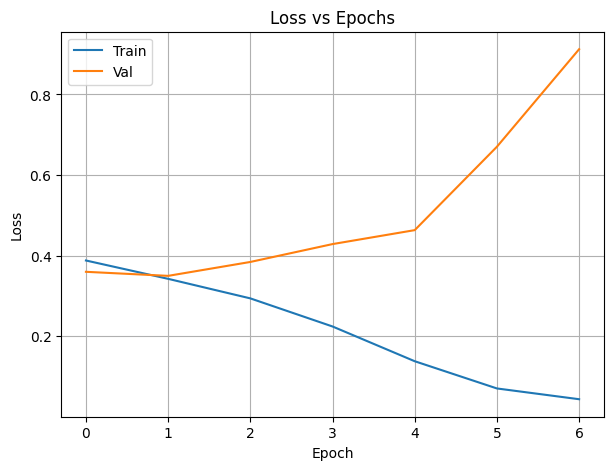

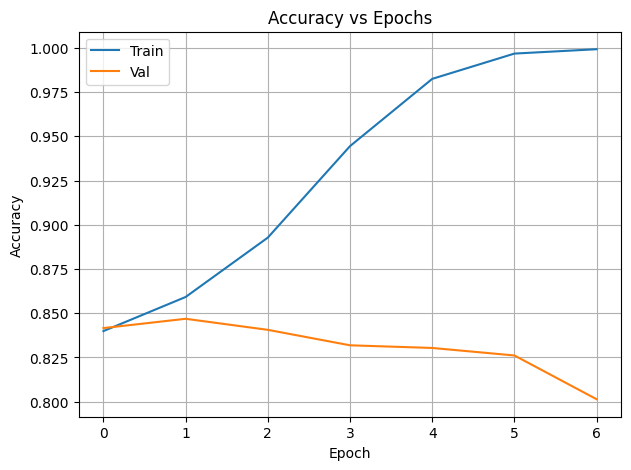

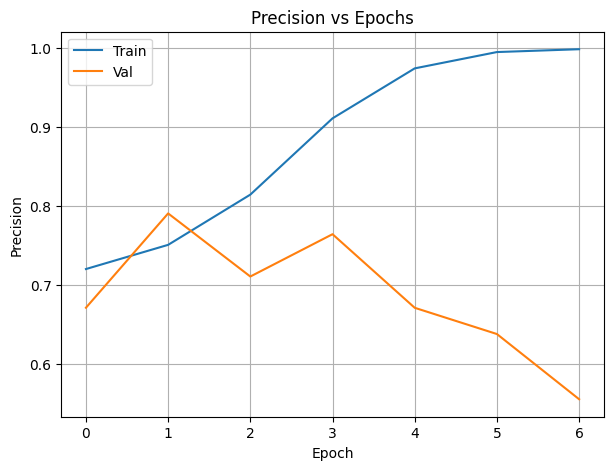

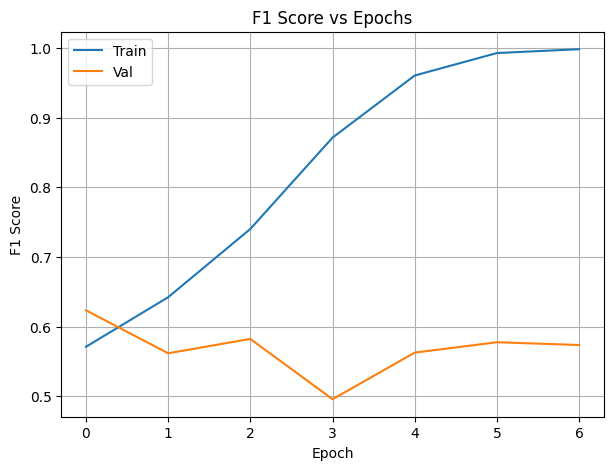

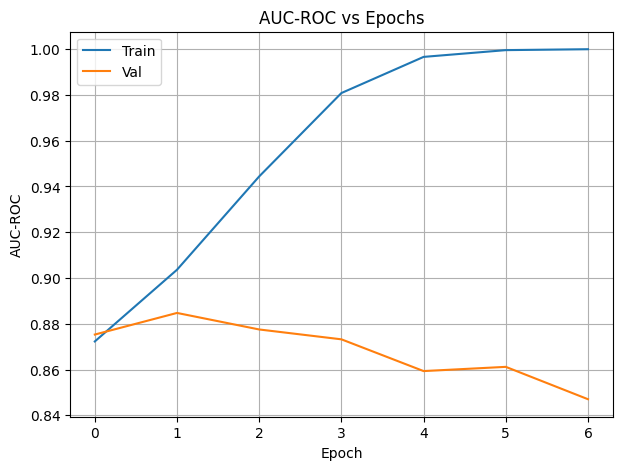

In [11]:
def plot_metric(name, ylabel):
    plt.figure(figsize=(7,5))
    plt.plot(history[f"train_{name}"], label="Train")
    plt.plot(history[f"val_{name}"],   label="Val")
    plt.xlabel("Epoch"); plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs Epochs"); plt.legend(); plt.grid(); plt.show()

for m,l in [("loss","Loss"),("acc","Accuracy"),("prec","Precision"),("f1","F1 Score"),("auc","AUC-ROC")]:
    plot_metric(m,l)

              precision    recall  f1-score   support

         0.0    0.86181   0.96130   0.90884      3101
         1.0    0.77941   0.47007   0.58645       902

    accuracy                        0.85061      4003
   macro avg    0.82061   0.71568   0.74764      4003
weighted avg    0.84324   0.85061   0.83620      4003



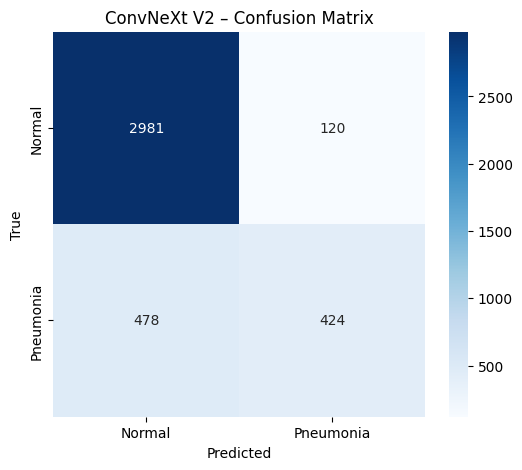

In [12]:
model.load_state_dict(torch.load(MODEL_SAVE))
model.eval()
probs, labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        probs.append(torch.sigmoid(model(x.to(device))).cpu())
        labels.append(y.unsqueeze(1))
probs  = torch.cat(probs).numpy()
labels = torch.cat(labels).numpy()
preds  = (probs > THRESHOLD).astype(int)
print(classification_report(labels, preds, digits=5))
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"])
plt.title("ConvNeXt V2 – Confusion Matrix")
plt.ylabel("True"); plt.xlabel("Predicted"); plt.show()